### Imports

In [1]:
import PIL
from PIL import Image
import requests
import torch
import numpy as np
from io import BytesIO
import matplotlib.pyplot as plt

from diffusers import AutoPipelineForInpainting
from diffusers.utils import load_image, make_image_grid

c:\Users\WeiLunKOHSoftwareArc\miniconda3\envs\diffusion_exp\lib\site-packages\diffusers\utils\outputs.py:63: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


### Load Model and Function

In [2]:
pipe = AutoPipelineForInpainting.from_pretrained(
    # "runwayml/stable-diffusion-inpainting",
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1", 
    torch_dtype=torch.float16, 
    variant="fp16",
# )
).to('cuda')
pipe.enable_model_cpu_offload()

def inpaint_image(
    prompt, 
    init_image, 
    mask_image,
    height=None, 
    width=None,
    strength=1.0,
    guidance_scale=7.5,
    padding_mask_crop=None
):    
    return pipe(
        prompt=prompt, 
        image=init_image, 
        mask_image=mask_image,
        height=height, 
        width=width,
        strength=strength,
        guidance_scale=guidance_scale,
        padding_mask_crop=padding_mask_crop
    ).images[0]

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


### Inpaint Image 1: Using Default Sample

c:\Users\WeiLunKOHSoftwareArc\miniconda3\envs\diffusion_exp\lib\site-packages\diffusers\models\attention_processor.py:1244: UserWarning: 1Torch was not compiled with flash attention. (Triggered internally at ..\aten\src\ATen\native\transformers\cuda\sdp_utils.cpp:263.)
  hidden_states = F.scaled_dot_product_attention(


  0%|          | 0/50 [00:00<?, ?it/s]

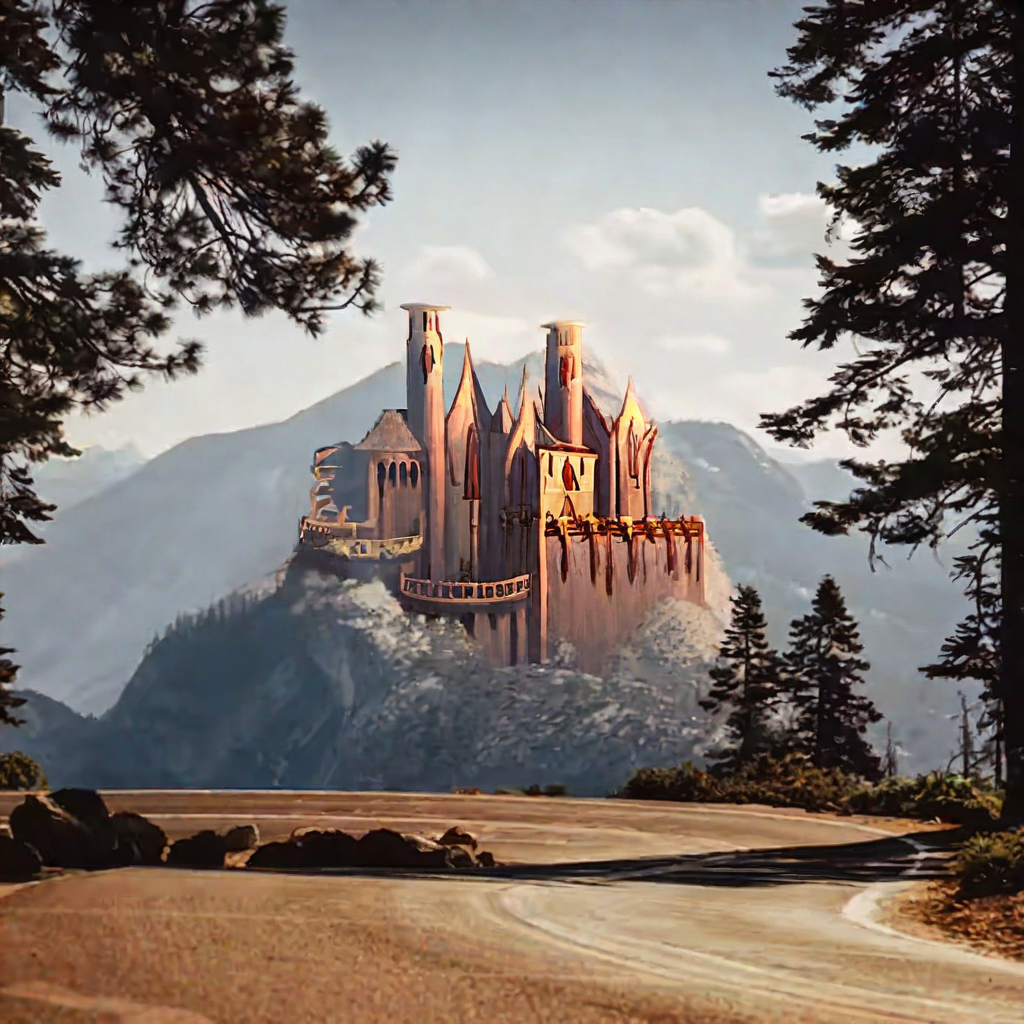

In [3]:
# def download_image(url):
#     response = requests.get(url)
#     return PIL.Image.open(BytesIO(response.content)).convert("RGB")

img_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint.png"
mask_url = "https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/diffusers/inpaint_mask.png"


prompt = "concept art digital painting of an elven castle, inspired by lord of the rings, highly detailed, 8k"
init_image = load_image(img_url).resize((512, 512))
mask_image = load_image(mask_url).resize((512, 512))

inpaint_image(prompt, init_image, mask_image)

### Inpaint Image 2: Own Sample

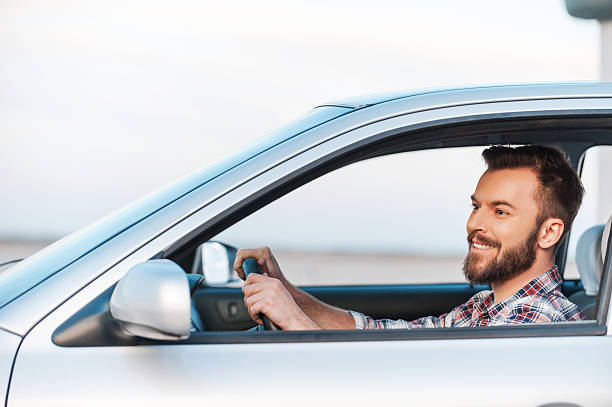

In [4]:
img_path = "data/base_image.jpg"
raw_image = Image.open(img_path).convert("RGB")
raw_image

In [5]:
raw_image.size

(612, 407)

#### Section to modify the masks

In [6]:
# Using SAM masks
human_mask_int = np.load("data/human_mask.npy")
human_mask_float = human_mask_int.astype(np.float32) # Convert to float
human_mask_image = Image.fromarray(human_mask_float * 255) # Convert to black and white imaage

car_mask_int = np.load("data/car_mask.npy")
car_mask_float = car_mask_int.astype(np.float32) # Convert to float
car_mask_image = Image.fromarray(car_mask_float * 255) # Convert to black and white imaage

# Blur the masks (optional)
# human_mask_image = pipe.mask_processor.blur(human_mask_image.convert("RGB"), blur_factor=1)
car_mask_image = pipe.mask_processor.blur(car_mask_image.convert("RGB"), blur_factor=10)

In [40]:
# Using rectangle masks
human_mask_image = Image.open("data/human_mask_blocks.png")
human_mask_image = pipe.mask_processor.blur(human_mask_image.convert("RGB"), blur_factor=10)

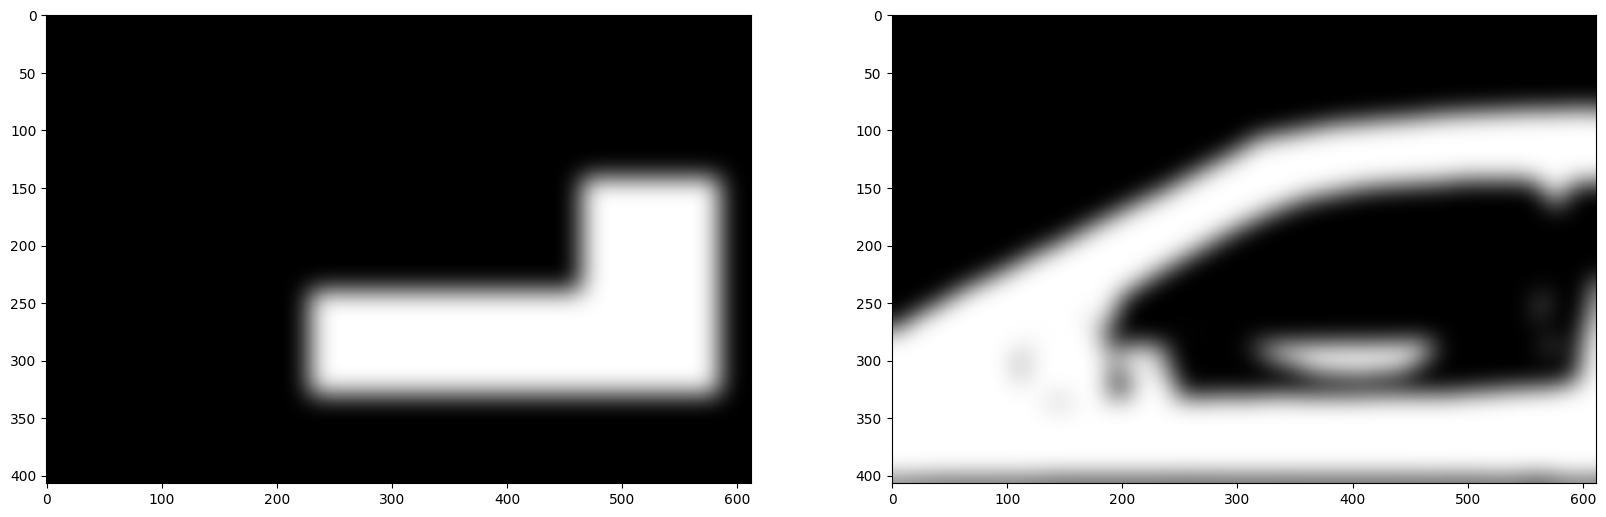

In [41]:
fig, axes = plt.subplots(1, 2, figsize=(20, 15))
axes[0].imshow(human_mask_image)
axes[1].imshow(car_mask_image)

#### Section to inpaint with chosen masks

  0%|          | 0/40 [00:00<?, ?it/s]

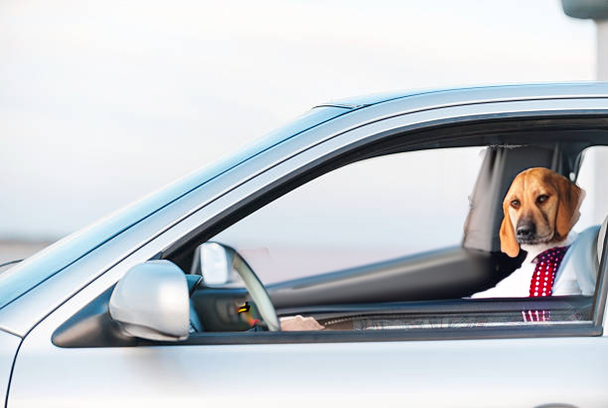

In [46]:
# human_prompt = "female asian in a car, highly detailed, realistic, 8k"
human_prompt = "dog driving a car with hands on the wheel"
inpaint_human = inpaint_image(
    human_prompt, 
    raw_image, 
    human_mask_image, 
    height=408, 
    width=608,
    strength=0.8,
    guidance_scale=10,
    padding_mask_crop=20
)
inpaint_human

  0%|          | 0/45 [00:00<?, ?it/s]

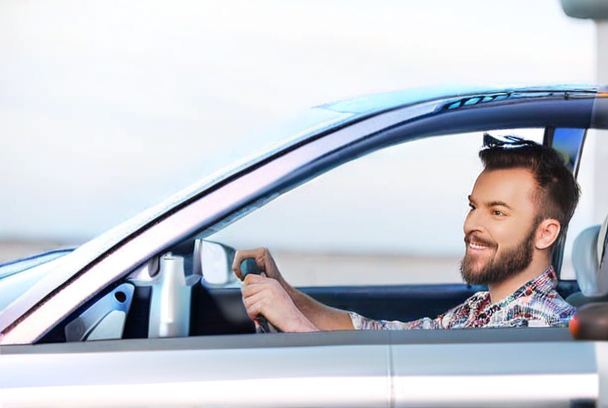

In [31]:
# car_prompt = "human driving a lamborghini, highly detailed, 8k"
car_prompt = "human driving a lamborghini, realistic"
inpaint_car = inpaint_image(
    car_prompt,
    raw_image, 
    car_mask_image, 
    height=408, 
    width=608,
    strength=0.9,
    guidance_scale=10,
    # padding_mask_crop=100
)
inpaint_car

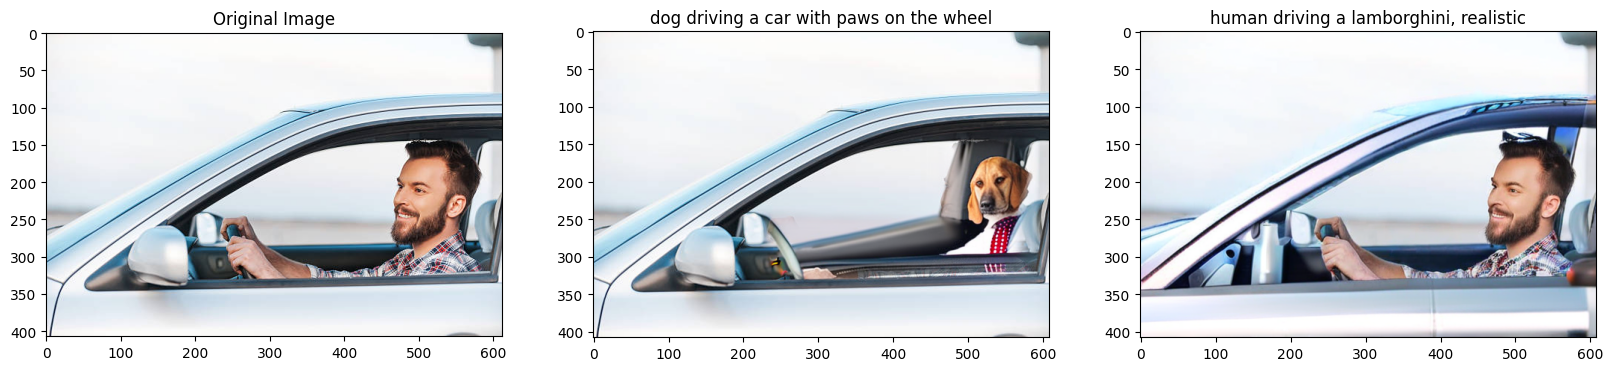

In [47]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))
axes[0].imshow(raw_image)
axes[0].title.set_text("Original Image")
axes[1].imshow(inpaint_human)
axes[1].title.set_text(human_prompt)
axes[2].imshow(inpaint_car)
axes[2].title.set_text(car_prompt)